# 계산

Recording...
Recording finished.
녹음된 오디오가 recorded_audio.wav에 저장되었습니다.
Recorded audio length: 5.0 seconds
Original Noise RMS: 0.3350
Anti-Noise RMS: 0.1002
Combined Noise RMS: 0.0123
Noise Reduction: 96.34%
결합된 파일이 combined_waveform2.wav에 저장되었습니다.


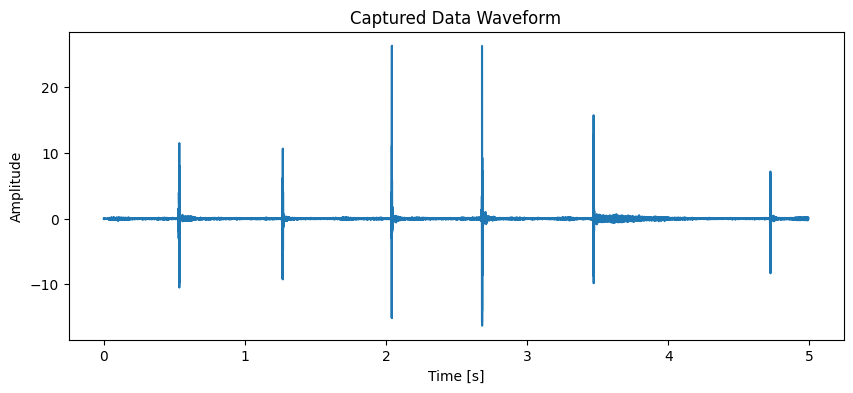

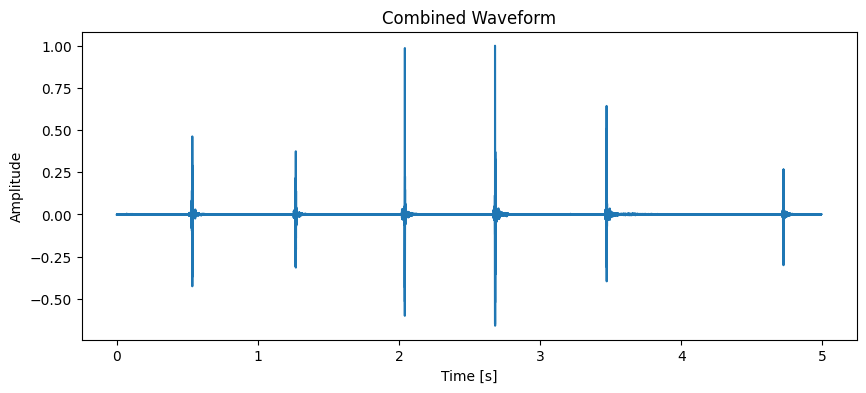

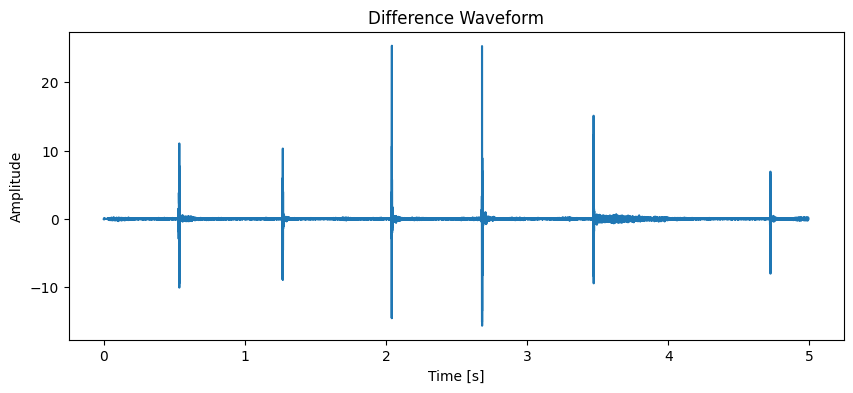

In [43]:
import numpy as np
import sounddevice as sd
import torch
import matplotlib.pyplot as plt
import pickle
import soundfile as sf

# RMS 계산 함수
def calculate_rms(signal):
    return np.sqrt(np.mean(signal**2))

# .pkl 파일에서 모델 로드
with open('/Users/chonakyung/LSTM2/Noise_Lower_LSTM_vol_2.pkl', 'rb') as model_file:
    model = pickle.load(model_file)


def process_and_concatenate(model, input_waveform, frame_size=1024):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    input_waveform = torch.tensor(input_waveform).unsqueeze(0).to(device).float()
    
    output_waveform = []
    
    for i in range(0, input_waveform.size(1), frame_size):
        input_frame = input_waveform[:, i:i+frame_size]
        if input_frame.size(1) == frame_size:
            with torch.no_grad():
                output_frame = model(input_frame).cpu().numpy().flatten()
                output_waveform.append(output_frame)
    
    # 결과를 이어붙이기
    output_waveform = np.concatenate(output_waveform)
    
    return output_waveform

# 시각화 함수
def plot_waveform(data, sample_rate, title):
    time_axis = np.linspace(0, len(data) / sample_rate, num=len(data))
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, data)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()

# 오디오 데이터 캡처 및 모델 출력
live_audio_data = capture_and_predict(duration=5)
sample_rate = 44100  # 샘플레이트 지정

# 녹음된 데이터의 길이 확인
recorded_duration = len(live_audio_data) / sample_rate
print(f"Recorded audio length: {recorded_duration} seconds")

# live_audio_data는 2D numpy array로 반환되기 때문에 1D로 변환 필요
live_audio_data = live_audio_data.squeeze()

# 모델 예측 및 결합된 데이터 생성
output_waveform = process_and_concatenate(model, live_audio_data, frame_size=1024)

# 두 데이터의 길이 일치화
min_length = min(len(live_audio_data), len(output_waveform))
original_data = live_audio_data[:min_length]
output_waveform = output_waveform[:min_length]

# 두 파형 결합
combined_data = original_data + output_waveform

# 결합된 데이터의 정규화 (클리핑 방지)
combined_data = combined_data / np.max(np.abs(combined_data))

# RMS 값 계산
rms_original = calculate_rms(original_data)
rms_anti_noise = calculate_rms(output_waveform)
rms_combined = calculate_rms(combined_data)

# 소음 감소율 계산
noise_reduction_percentage = ((rms_original - rms_combined) / rms_original) * 100

# 결과 출력
print(f"Original Noise RMS: {rms_original:.4f}")
print(f"Anti-Noise RMS: {rms_anti_noise:.4f}")
print(f"Combined Noise RMS: {rms_combined:.4f}")
print(f"Noise Reduction: {noise_reduction_percentage:.2f}%")

# 결합된 데이터를 .wav 파일로 저장
output_wav_path = 'combined_waveform2.wav'
sf.write(output_wav_path, combined_data, sample_rate)

print(f"결합된 파일이 {output_wav_path}에 저장되었습니다.")

# 전체 구간에서의 파형 시각화
plot_waveform(original_data, sample_rate, "Captured Data Waveform")
plot_waveform(combined_data, sample_rate, "Combined Waveform")

# 결합 후의 차이 (원본 데이터에 대한 영향도 측정)
difference = original_data - combined_data
plot_waveform(difference, sample_rate, "Difference Waveform")


In [45]:
import soundfile as sf

# 'combined_waveform2.wav' 파일을 로드
output_wav_path = '/Users/chonakyung/LSTM2/combined_waveform2.wav'

# 파일에서 오디오 데이터를 읽음
data, sample_rate = sf.read(output_wav_path)

# 데이터의 길이(샘플 수)를 출력
length_data_points = len(data)
print(f"combined_waveform2.wav 파일의 데이터 길이는 {length_data_points} 포인트입니다.")


combined_waveform2.wav 파일의 데이터 길이는 220160 포인트입니다.


# 실시간 오디오 테스트

Recording...
Recording finished.
Recorded audio length: 5.0 seconds


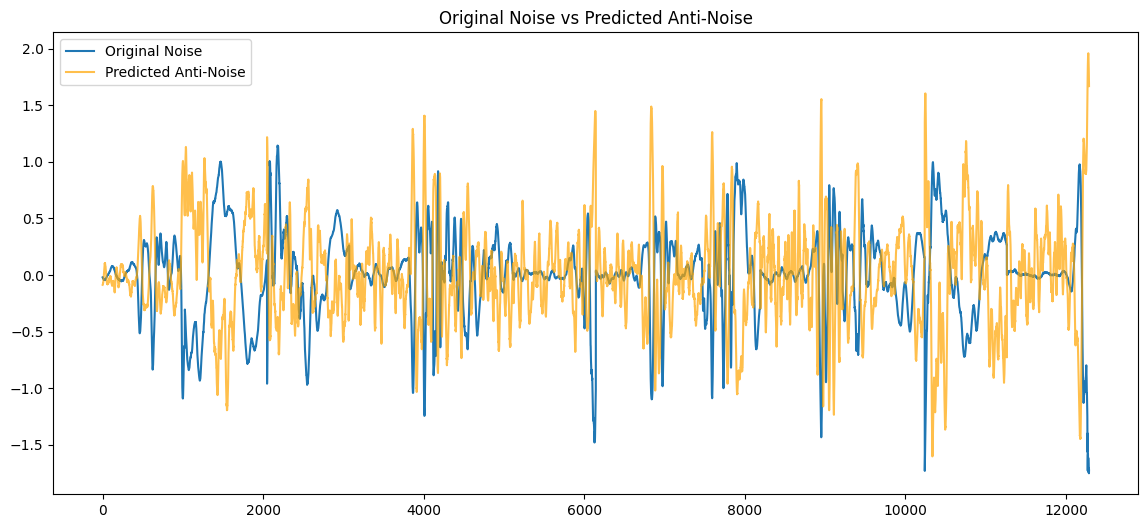

결합된 파일이 combined_waveform.wav에 저장되었습니다.


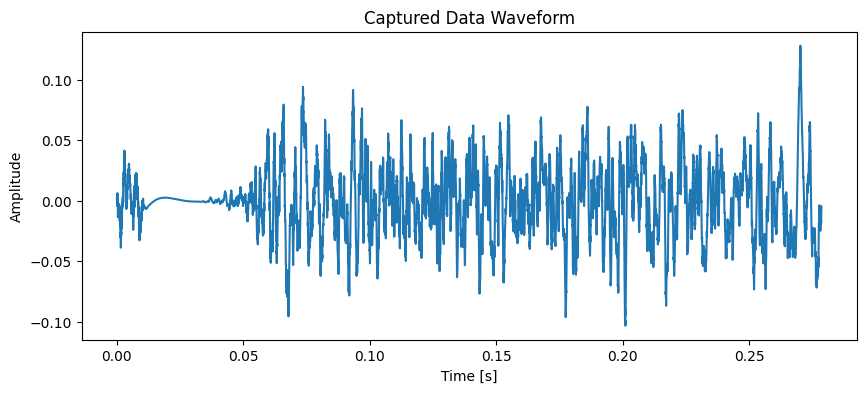

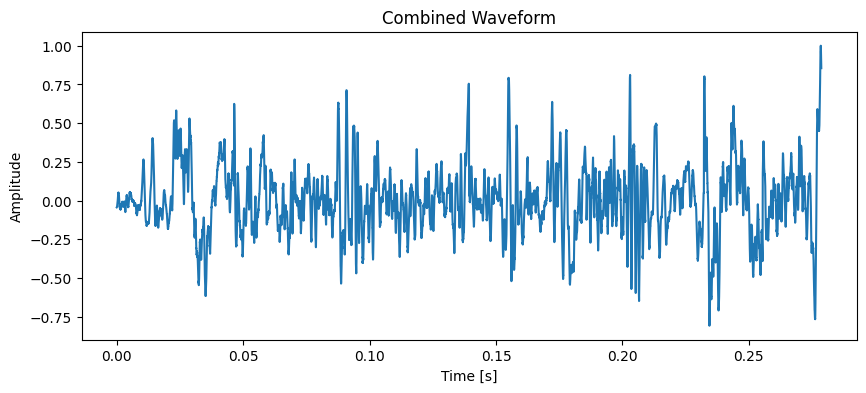

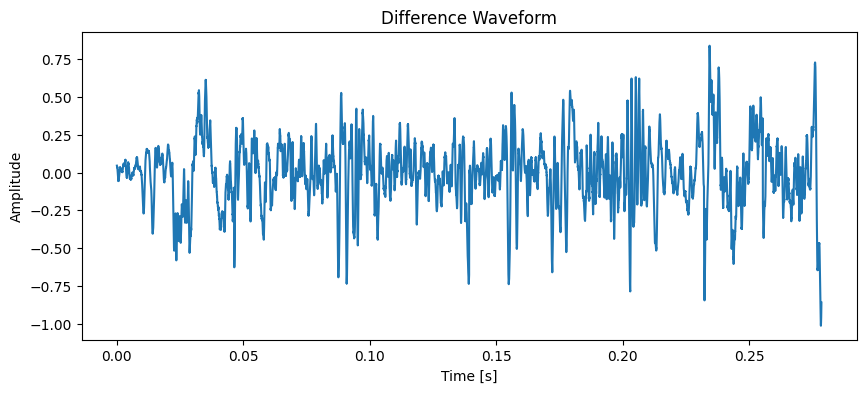

In [14]:
import numpy as np
import sounddevice as sd
import torch
import matplotlib.pyplot as plt
import pickle
import soundfile as sf  # 올바른 모듈 import
from torch.utils.data import DataLoader, Dataset

# .pkl 파일에서 모델 로드
with open('/Users/chonakyung/LSTM2/Noise_Lower_LSTM_vol_1.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

# 오디오 데이터 캡처 및 모델 예측 함수
def capture_and_predict(duration=1, samplerate=44100):
    # 오디오 데이터를 캡처
    print("Recording...")
    audio_data = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=1, dtype='float32')
    sd.wait()  # 녹음 완료까지 대기
    print("Recording finished.")
    
    return audio_data

def evaluate_and_plot_with_dataloader(model, dataloader, total_length):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    all_input_waveforms = []
    all_output_waveforms = []
    
    for inputs, _ in dataloader:
        inputs = inputs.to(device)
        inputs = inputs.squeeze(-1).float()
        with torch.no_grad():
            outputs = model(inputs)
            
        # 각 배치를 평탄화하고 리스트에 추가
        for i in range(inputs.size(0)):
            input_waveform = inputs[i].cpu().numpy().flatten()
            output_waveform = outputs[i].cpu().numpy().flatten()
            all_input_waveforms.append(input_waveform)
            all_output_waveforms.append(output_waveform)
    
    # 모든 배치를 하나의 연속적인 파형으로 결합
    all_input_waveforms = np.concatenate(all_input_waveforms)
    all_output_waveforms = np.concatenate(all_output_waveforms)

    # 필요한 길이만큼 잘라서 시각화 (전체 길이 맞춤)
    all_input_waveforms = all_input_waveforms[:total_length]
    all_output_waveforms = all_output_waveforms[:total_length]
    
    # 결과 시각화
    plt.figure(figsize=(14, 6))
    plt.plot(all_input_waveforms, label='Original Noise')
    plt.plot(all_output_waveforms, label='Predicted Anti-Noise', color='orange', alpha=0.7)
    plt.title('Original Noise vs Predicted Anti-Noise')
    plt.legend()
    plt.show()

    return all_output_waveforms

class NoiseDataset(Dataset):
    def __init__(self, waveform, sample_rate=16000, frame_size=1024, threshold=0.05):
        self.waveform = torch.tensor(waveform)
        self.sample_rate = sample_rate
        self.frame_size = frame_size
        self.threshold = threshold
        self.noise_indices = self._detect_noise(self.waveform)
        
    def _detect_noise(self, waveform):
        noise_indices = []
        waveform_length = waveform.size(0)
        
        for i in range(0, waveform_length - self.frame_size, self.frame_size):
            frame = waveform[i:i+self.frame_size]
            frame_energy = frame.pow(2).mean().item()
            if frame_energy > self.threshold:
                noise_indices.append(i)
                
        return noise_indices

    def __len__(self):
        return len(self.noise_indices)
    
    def __getitem__(self, idx):
        start_idx = self.noise_indices[idx]
        end_idx = start_idx + self.frame_size

        noisy_segment = self.waveform[start_idx:end_idx]
        
        return noisy_segment.unsqueeze(-1), noisy_segment.unsqueeze(-1)

def load_datasets_from_waveform(waveform, sample_rate=16000, frame_size=1024, threshold=0.05):
    dataset = NoiseDataset(waveform, sample_rate, frame_size, threshold)
    return dataset

# 시각화 함수
def plot_waveform(data, sample_rate, title):
    time_axis = np.linspace(0, len(data) / sample_rate, num=len(data))
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, data)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()

# 오디오 데이터 캡처 및 모델 출력
live_audio_data = capture_and_predict(duration=5)
sample_rate = 44100  # samplerate 지정

# 녹음된 데이터의 길이 확인
print(f"Recorded audio length: {len(live_audio_data) / sample_rate} seconds")

# live_audio_data는 2D numpy array로 반환되기 때문에 1D로 변환 필요
live_audio_data = live_audio_data.squeeze()

# 노이즈 데이터셋 생성
dataset = load_datasets_from_waveform(live_audio_data, sample_rate=sample_rate)
live_data = DataLoader(dataset, batch_size=64, shuffle=True)

# 모델 예측 및 시각화
output_form = evaluate_and_plot_with_dataloader(model, live_data, total_length=len(live_audio_data))

# 두 데이터의 길이 일치화
min_length = min(len(live_audio_data), len(output_form))
original_data = live_audio_data[:min_length]
output_form = output_form[:min_length]

# 두 파형 결합
combined_data = original_data + output_form

# 결합된 데이터의 정규화 (클리핑 방지)
combined_data = combined_data / np.max(np.abs(combined_data))

# 결합된 데이터를 .wav 파일로 저장
output_wav_path = 'combined_waveform.wav'
sf.write(output_wav_path, combined_data, sample_rate)

print(f"결합된 파일이 {output_wav_path}에 저장되었습니다.")


# 전체 구간에서의 파형 시각화
plot_waveform(original_data, sample_rate, "Captured Data Waveform")
plot_waveform(combined_data, sample_rate, "Combined Waveform")

# 결합 후의 차이 (원본 데이터에 대한 영향도 측정)
difference = original_data - combined_data
plot_waveform(difference, sample_rate, "Difference Waveform")


In [44]:
import numpy as np
import sounddevice as sd
import torch
import matplotlib.pyplot as plt
import pickle
import soundfile as sf  # 올바른 모듈 import
from torch.utils.data import DataLoader, Dataset

def get_audio_length(file_path):
    data, sample_rate = sf.read(file_path)
    duration = len(data) / sample_rate
    return duration

recorded_audio_path = '/Users/chonakyung/LSTM2/recorded_audio.wav' 

recorded_audio_length = get_audio_length(recorded_audio_path)
print(f"Recorded audio length: {recorded_audio_length:.2f} seconds")


Recorded audio length: 5.00 seconds


Recording...
Recording finished.
Recorded audio length: 5.0 seconds


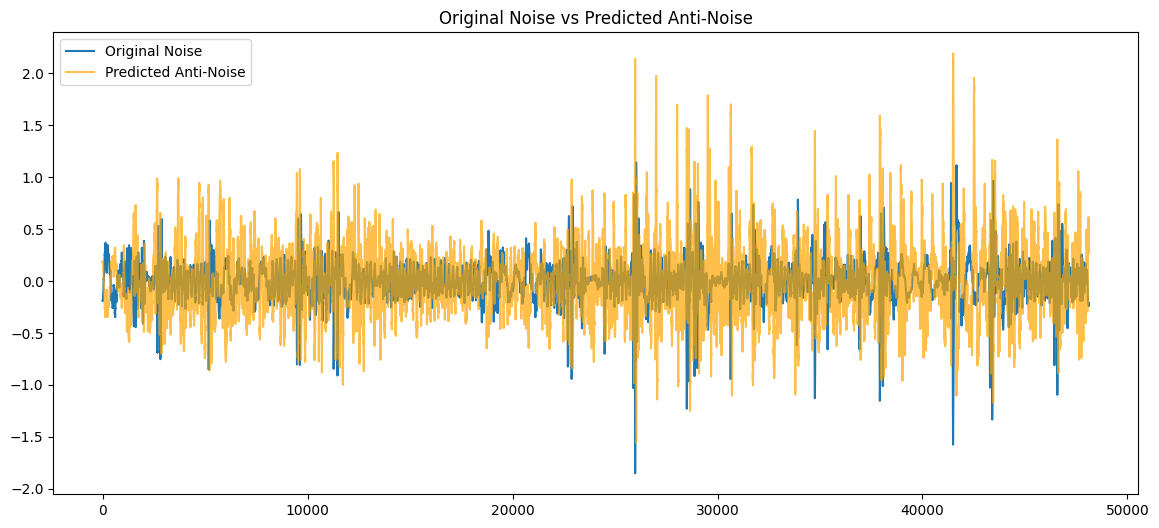

결합된 파일이 combined_waveform.wav에 저장되었습니다.


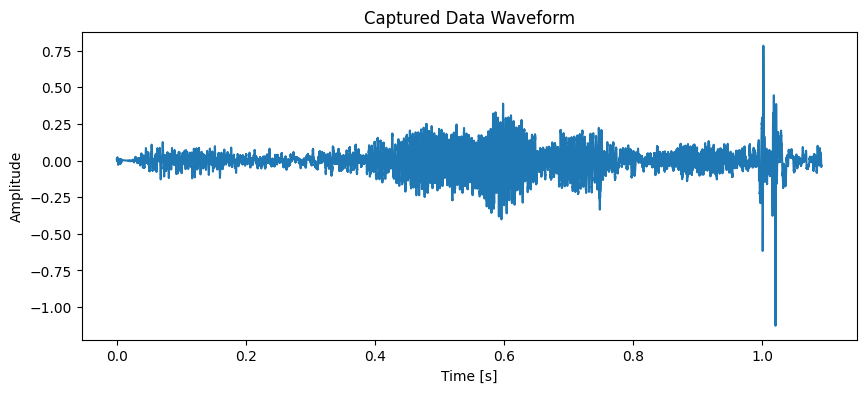

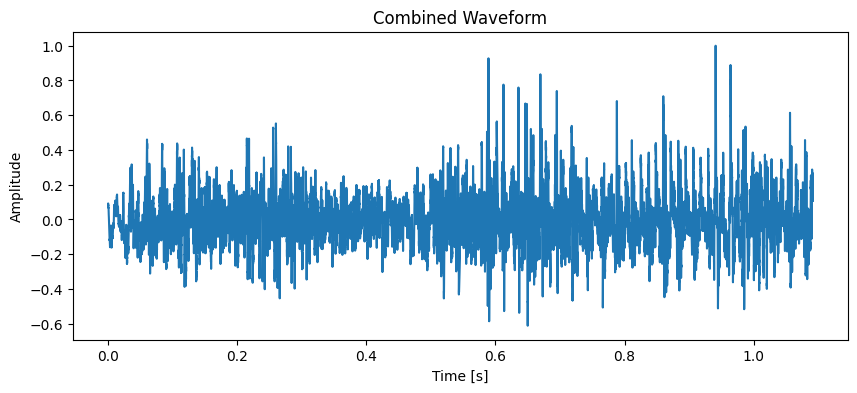

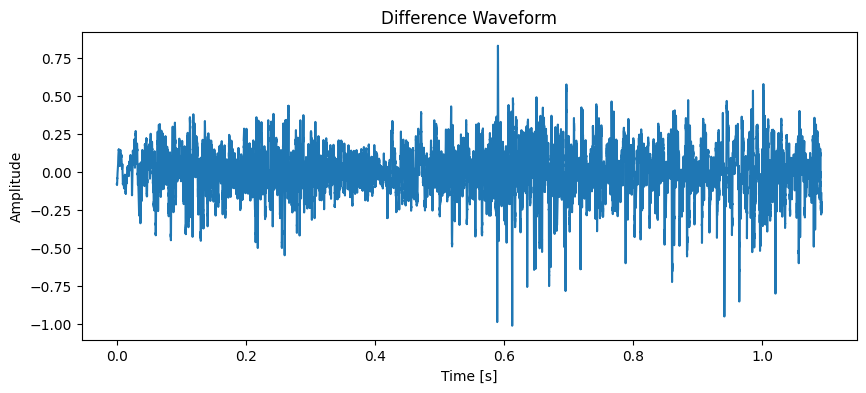

In [19]:
import numpy as np
import sounddevice as sd
import torch
import matplotlib.pyplot as plt
import pickle
import soundfile as sf
from torch.utils.data import DataLoader, Dataset

# .pkl 파일에서 모델 로드
with open('/Users/chonakyung/LSTM2/Noise_Lower_LSTM_vol_2.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

# 오디오 데이터 캡처 함수
def capture_and_predict(duration=5, samplerate=44100):
    # 오디오 데이터를 캡처
    print("Recording...")
    audio_data = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=1, dtype='float32')
    sd.wait()  # 녹음 완료까지 대기
    print("Recording finished.")
    
    return audio_data

def evaluate_and_plot_with_dataloader(model, dataloader, total_length):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    all_input_waveforms = []
    all_output_waveforms = []
    
    for inputs, _ in dataloader:
        inputs = inputs.to(device)
        inputs = inputs.squeeze(-1).float()
        with torch.no_grad():
            outputs = model(inputs)
            
        # 각 배치를 평탄화하고 리스트에 추가
        for i in range(inputs.size(0)):
            input_waveform = inputs[i].cpu().numpy().flatten()
            output_waveform = outputs[i].cpu().numpy().flatten()
            all_input_waveforms.append(input_waveform)
            all_output_waveforms.append(output_waveform)
    
    # 모든 배치를 하나의 연속적인 파형으로 결합
    all_input_waveforms = np.concatenate(all_input_waveforms)
    all_output_waveforms = np.concatenate(all_output_waveforms)

    # 필요한 길이만큼 잘라서 시각화 (전체 길이 맞춤)
    all_input_waveforms = all_input_waveforms[:total_length]
    all_output_waveforms = all_output_waveforms[:total_length]
    
    # 결과 시각화
    plt.figure(figsize=(14, 6))
    plt.plot(all_input_waveforms, label='Original Noise')
    plt.plot(all_output_waveforms, label='Predicted Anti-Noise', color='orange', alpha=0.7)
    plt.title('Original Noise vs Predicted Anti-Noise')
    plt.legend()
    plt.show()

    return all_output_waveforms

class NoiseDataset(Dataset):
    def __init__(self, waveform, sample_rate=16000, frame_size=1024, threshold=0.05):
        self.waveform = torch.tensor(waveform)
        self.sample_rate = sample_rate
        self.frame_size = frame_size
        self.threshold = threshold
        self.noise_indices = self._detect_noise(self.waveform)
        
    def _detect_noise(self, waveform):
        noise_indices = []
        waveform_length = waveform.size(0)
        
        for i in range(0, waveform_length - self.frame_size, self.frame_size):
            frame = waveform[i:i+self.frame_size]
            frame_energy = frame.pow(2).mean().item()
            if frame_energy > self.threshold:
                noise_indices.append(i)
                
        return noise_indices

    def __len__(self):
        return len(self.noise_indices)
    
    def __getitem__(self, idx):
        start_idx = self.noise_indices[idx]
        end_idx = start_idx + self.frame_size

        noisy_segment = self.waveform[start_idx:end_idx]
        
        return noisy_segment.unsqueeze(-1), noisy_segment.unsqueeze(-1)

def load_datasets_from_waveform(waveform, sample_rate=16000, frame_size=1024, threshold=0.05):
    dataset = NoiseDataset(waveform, sample_rate, frame_size, threshold)
    return dataset

# 시각화 함수
def plot_waveform(data, sample_rate, title):
    time_axis = np.linspace(0, len(data) / sample_rate, num=len(data))
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, data)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()

# 오디오 데이터 캡처 및 모델 출력
live_audio_data = capture_and_predict(duration=5)
sample_rate = 44100  # 샘플레이트 지정

# 녹음된 데이터의 길이 확인
recorded_duration = len(live_audio_data) / sample_rate
print(f"Recorded audio length: {recorded_duration} seconds")

# live_audio_data는 2D numpy array로 반환되기 때문에 1D로 변환 필요
live_audio_data = live_audio_data.squeeze()

# 노이즈 데이터셋 생성
dataset = load_datasets_from_waveform(live_audio_data, sample_rate=sample_rate,threshold= 0.01)
live_data = DataLoader(dataset, batch_size=64, shuffle=True)

# 모델 예측 및 시각화
output_form = evaluate_and_plot_with_dataloader(model, live_data, total_length=len(live_audio_data))

# 두 데이터의 길이 일치화
min_length = min(len(live_audio_data), len(output_form))
original_data = live_audio_data[:min_length]
output_form = output_form[:min_length]

# 두 파형 결합
combined_data = original_data + output_form

# 결합된 데이터의 정규화 (클리핑 방지)
combined_data = combined_data / np.max(np.abs(combined_data))

# 결합된 데이터를 .wav 파일로 저장
output_wav_path = 'combined_waveform.wav'
sf.write(output_wav_path, combined_data, sample_rate)

print(f"결합된 파일이 {output_wav_path}에 저장되었습니다.")

# 전체 구간에서의 파형 시각화
plot_waveform(original_data, sample_rate, "Captured Data Waveform")
plot_waveform(combined_data, sample_rate, "Combined Waveform")

# 결합 후의 차이 (원본 데이터에 대한 영향도 측정)
difference = original_data - combined_data
plot_waveform(difference, sample_rate, "Difference Waveform")


Recording...
Recording finished.
녹음된 오디오가 recorded_audio.wav에 저장되었습니다.
Recorded audio length: 5.0 seconds
결합된 파일이 combined_waveform2.wav에 저장되었습니다.


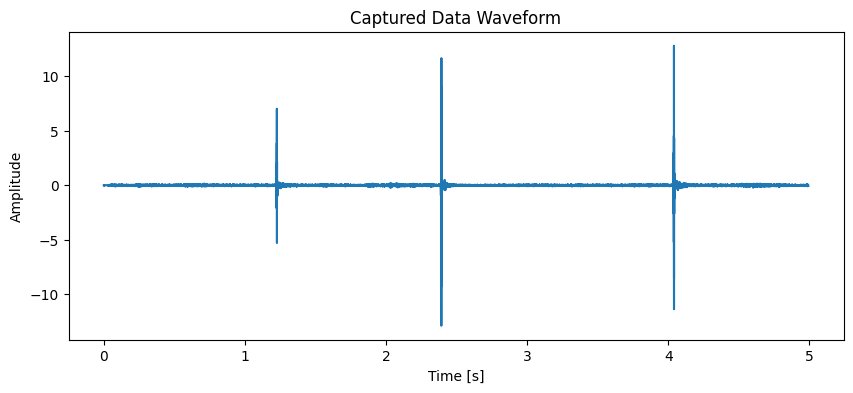

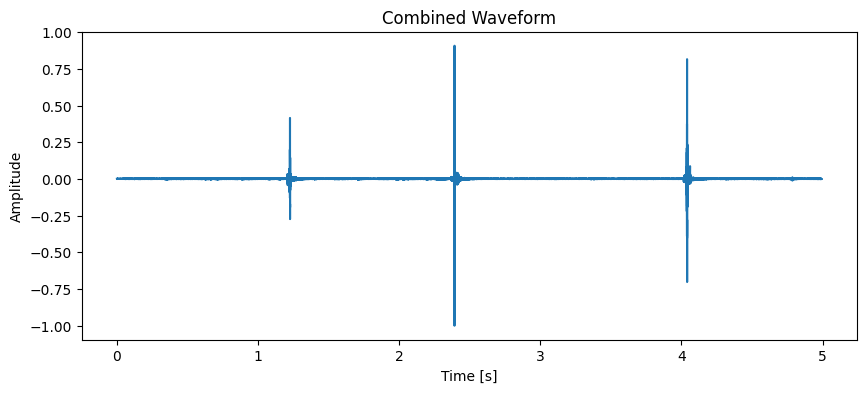

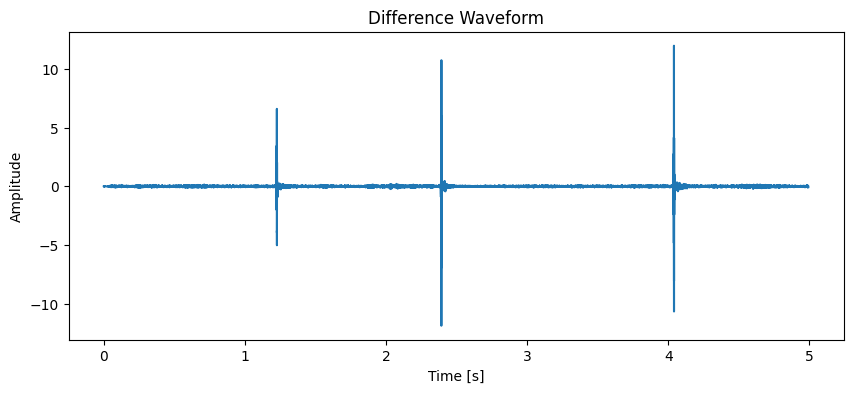

In [23]:
import numpy as np
import sounddevice as sd
import torch
import matplotlib.pyplot as plt
import pickle
import soundfile as sf
from torch.utils.data import DataLoader, Dataset

# .pkl 파일에서 모델 로드
with open('/Users/chonakyung/LSTM2/Noise_Lower_LSTM_vol_2.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

# 오디오 데이터 캡처 함수
def capture_and_predict(duration=5, samplerate=44100):
    # 오디오 데이터를 캡처
    print("Recording...")
    audio_data = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=1, dtype='float32')
    sd.wait()  # 녹음 완료까지 대기
    print("Recording finished.")

    # 녹음된 오디오 데이터를 .wav 파일로 저장
    original_wav_path = 'recorded_audio.wav'
    sf.write(original_wav_path, audio_data, samplerate)
    print(f"녹음된 오디오가 {original_wav_path}에 저장되었습니다.")
    
    return audio_data

def process_and_concatenate(model, input_waveform, frame_size=1024):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    input_waveform = torch.tensor(input_waveform).unsqueeze(0).to(device).float()
    
    output_waveform = []
    
    for i in range(0, input_waveform.size(1), frame_size):
        input_frame = input_waveform[:, i:i+frame_size]
        if input_frame.size(1) == frame_size:
            with torch.no_grad():
                output_frame = model(input_frame).cpu().numpy().flatten()
                output_waveform.append(output_frame)
    
    # 결과를 이어붙이기
    output_waveform = np.concatenate(output_waveform)
    
    return output_waveform

# 시각화 함수
def plot_waveform(data, sample_rate, title):
    time_axis = np.linspace(0, len(data) / sample_rate, num=len(data))
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, data)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()

# 오디오 데이터 캡처 및 모델 출력
live_audio_data = capture_and_predict(duration=5)
sample_rate = 44100  # 샘플레이트 지정

# 녹음된 데이터의 길이 확인
recorded_duration = len(live_audio_data) / sample_rate
print(f"Recorded audio length: {recorded_duration} seconds")

# live_audio_data는 2D numpy array로 반환되기 때문에 1D로 변환 필요
live_audio_data = live_audio_data.squeeze()

# 모델 예측 및 결합된 데이터 생성
output_waveform = process_and_concatenate(model, live_audio_data, frame_size=1024)

# 두 데이터의 길이 일치화
min_length = min(len(live_audio_data), len(output_waveform))
original_data = live_audio_data[:min_length]
output_waveform = output_waveform[:min_length]

# 두 파형 결합
combined_data = original_data + output_waveform

# 결합된 데이터의 정규화 (클리핑 방지)
combined_data = combined_data / np.max(np.abs(combined_data))

# 결합된 데이터를 .wav 파일로 저장
output_wav_path = 'combined_waveform2.wav'
sf.write(output_wav_path, combined_data, sample_rate)

print(f"결합된 파일이 {output_wav_path}에 저장되었습니다.")

# 전체 구간에서의 파형 시각화
plot_waveform(original_data, sample_rate, "Captured Data Waveform")
plot_waveform(combined_data, sample_rate, "Combined Waveform")

# 결합 후의 차이 (원본 데이터에 대한 영향도 측정)
difference = original_data - combined_data
plot_waveform(difference, sample_rate, "Difference Waveform")


Recording...
Recording finished.
Recorded audio length: 5.0 seconds


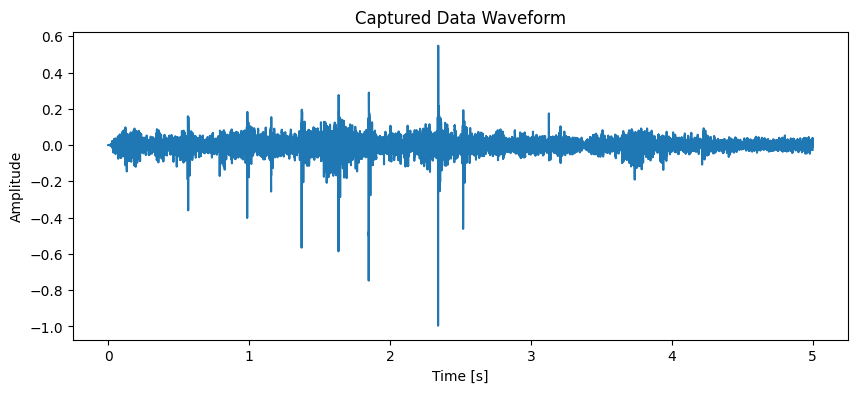

In [16]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

# 오디오 데이터 캡처 함수
def capture_and_predict(duration=5, samplerate=44100):
    # 오디오 데이터를 캡처
    print("Recording...")
    audio_data = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=1, dtype='float32')
    sd.wait()  # 녹음 완료까지 대기
    print("Recording finished.")
    
    return audio_data

# 시각화 함수
def plot_waveform(data, sample_rate, title):
    time_axis = np.linspace(0, len(data) / sample_rate, num=len(data))
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, data)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()

# 오디오 데이터 캡처
duration = 5  # 5초간 녹음
sample_rate = 44100  # 샘플링 레이트 설정
live_audio_data = capture_and_predict(duration=duration, samplerate=sample_rate)

# 녹음된 데이터의 길이 확인
recorded_duration = len(live_audio_data) / sample_rate
print(f"Recorded audio length: {recorded_duration} seconds")

# live_audio_data는 2D numpy array로 반환되기 때문에 1D로 변환 필요
live_audio_data = live_audio_data.squeeze()

# 캡처된 데이터 시각화
plot_waveform(live_audio_data, sample_rate, "Captured Data Waveform")
